# Assignment

# Supervised Learning

Work assembled by Alejandro Gonçalves, Pedro Fernandes, Francisca Mihalache.

## Table of Contents

1. [Introduction](#introduction)

2. [Chosen Algorithm](#chosen-algorithm)

3. [Metrics](#metrics)
            
4. [Distances](#distances)
   - 4.1. [Euclidian Distance](#euclidian-distance)
   - 4.2. [L2 Distance](#l2-distance)
   - 4.3. [Euclidian Distance (features)](#euclidian-distance-features)
   - 4.4. [Cosine Similarity](#cosine-similarity)
   - 4.5. [Manhattan Distance](#manhattan-distance)
   - 4.6. [Jaccard Distance](#jaccard-distance)

5. [Base](#base)

6. [Improved Algorithm](#improved-algorithm)

7. [Comparisons](#comparisons) 


## Introduction

In this assignment we'll dive into a selected Machine Learning (ML) algorithm, understanding its theory and testing its performance. We'll explore benchmarking methodologies and differentiate between ML research and practical application, ensuring a balanced understanding of theory and practice in ML.

### Imports
To begin with, we need to import some modules.

In [39]:
import pandas as pd
import math
import numpy as np
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report
from numpy.linalg import norm
from sklearn.decomposition import PCA
import openml as oml
from pandas.api.types import is_numeric_dtype
from random import seed
from random import randrange
from math import sqrt
from numpy import array
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV,cross_validate,LeaveOneOut
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error,mean_squared_error, r2_score, f1_score,ConfusionMatrixDisplay,roc_curve,roc_auc_score, auc
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

### Reading and cleaning the dataset

In [40]:
df1 = pd.read_csv('csvs\\breast.csv')
df1.head(5)

,id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1,5,1,1,1,2,1,3,1,1,benign
1,2,5,4,4,5,7,10,3,2,1,benign
2,3,3,1,1,1,2,2,3,1,1,benign
3,4,6,8,8,1,3,4,3,7,1,benign
4,5,4,1,1,3,2,1,3,1,1,benign


In [41]:
# If exists any missing values
print(df1.isnull().sum())

id                       0
Clump_Thickness          0
Cell_Size_Uniformity     0
Cell_Shape_Uniformity    0
Marginal_Adhesion        0
Single_Epi_Cell_Size     0
Bare_Nuclei              0
Bland_Chromatin          0
Normal_Nucleoli          0
Mitoses                  0
Class                    0
dtype: int64


In [42]:
# Replacing benign with 0 and malignant with 1 to be easier to understand and removing the lines that "?" is present. 
df1['Class'] = df1['Class'].replace({'benign': 0, 'malignant': 1})
df1['Bare_Nuclei'].replace('?', np.nan, inplace=True)
df1['Bare_Nuclei'] = pd.to_numeric(df1['Bare_Nuclei'], errors='coerce')
df1.dropna(subset=['Bare_Nuclei'], inplace=True)
df1.head()

C:\Users\aleja\AppData\Local\Temp\ipykernel_1588\727482383.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Class'] = df1['Class'].replace({'benign': 0, 'malignant': 1})
C:\Users\aleja\AppData\Local\Temp\ipykernel_1588\727482383.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Bare_N

,id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1,5,1,1,1,2,1.0,3,1,1,0
1,2,5,4,4,5,7,10.0,3,2,1,0
2,3,3,1,1,1,2,2.0,3,1,1,0
3,4,6,8,8,1,3,4.0,3,7,1,0
4,5,4,1,1,3,2,1.0,3,1,1,0


In [43]:
df1.describe()

,id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,352.355783,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,202.563927,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,177.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,356.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,527.500000,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [44]:
cols1 = ['Clump_Thickness','Cell_Size_Uniformity']
X1 = df1[cols1]
y1 = df1['Class']

<Axes: xlabel='Clump_Thickness', ylabel='Cell_Size_Uniformity'>

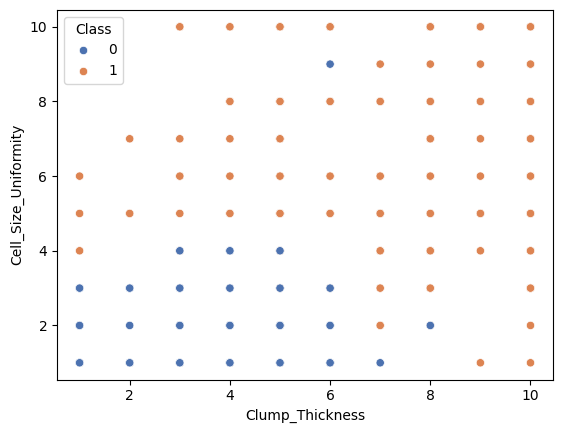

In [45]:
sns.scatterplot(x = X1['Clump_Thickness'], y = X1['Cell_Size_Uniformity'], hue = y1, palette = "deep")

## Chosen Algorithm

For this assignment, we decided to use KNN. [[more about K-Nearest Neighbors]](#knnk-nearest-neighbors)

In our initial approach, we will implement the algorithm without modifications and analyze the outcomes. Sencondly, we aim to enhance these results by implementing a modified algorithm for comparison. We will adjust the number of k-neighbors, explore different distance methods, and experiment with various features to achieve this improvement.

[[go back to the top]](#table-of-contents)

## Metrics
[[go back to the topic]](#chosen-algorithm)

The metrics.py file contains various performance evaluation functions

In [46]:
# coding:utf-8

EPS = 1e-15


def unhot(function):
    """Convert one-hot representation into one column."""

    def wrapper(actual, predicted):
        if len(actual.shape) > 1 and actual.shape[1] > 1:
            actual = actual.argmax(axis=1)
        if len(predicted.shape) > 1 and predicted.shape[1] > 1:
            predicted = predicted.argmax(axis=1)
        return function(actual, predicted)

    return wrapper


def absolute_error(actual, predicted):
    return np.abs(actual - predicted)


@unhot
def classification_error(actual, predicted):
    return (actual != predicted).sum() / float(actual.shape[0])


@unhot
def accuracy(actual, predicted):
    return 1.0 - classification_error(actual, predicted)


def mean_absolute_error(actual, predicted):
    return np.mean(absolute_error(actual, predicted))


def squared_error(actual, predicted):
    return (actual - predicted) ** 2


def squared_log_error(actual, predicted):
    return (np.log(np.array(actual) + 1) - np.log(np.array(predicted) + 1)) ** 2


def mean_squared_log_error(actual, predicted):
    return np.mean(squared_log_error(actual, predicted))


def mean_squared_error(actual, predicted):
    return np.mean(squared_error(actual, predicted))


def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def root_mean_squared_log_error(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))


def logloss(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss / float(actual.shape[0])


def hinge(actual, predicted):
    return np.mean(np.max(1.0 - actual * predicted, 0.0))


def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))


# aliases
mse = mean_squared_error
rmse = root_mean_squared_error
mae = mean_absolute_error


def get_metric(name):
    """Return metric function by name"""
    try:
        return globals()[name]
    except Exception:
        raise ValueError("Invalid metric function.")

## Distances
[[go back to the topic]](#chosen-algorithm)

The inicial github file provides these functions: 

- the Euclidean distance 

- the L2 distance matrix for a set of points in a dataset.
  
But, as said above, we'll explore different distance methods, like:
- Euclidean distance (features)
- Cosine Similarity
- Manhattan Distance
- Jaccard Distance


### Euclidian Distance
[[go back to the topic]](#distances)

This function is designed to calculate the distance between two individual points p1 and p2.

In [47]:
# coding:utf-8
def euclidean_distance(a, b):
    if isinstance(a, list) and isinstance(b, list):
        a = np.array(a)
        b = np.array(b)

    return math.sqrt(sum((a - b) ** 2))


### L2 Distance
[[go back to the topic]](#distances)


The function l2_distance(X) calculates the pairwise L2 or Euclidean distances between rows of a matrix X. This matrix X is expected to be a two-dimensional NumPy array where each row represents a point in a multidimensional space. 

In [48]:
def l2_distance(X):
    sum_X = np.sum(X * X, axis=1)
    return (-2 * np.dot(X, X.T) + sum_X).T + sum_X

### Euclidian Distance (features)
[[go back to the topic]](#distances)

This function is designed to calculate the Euclidean distances between a single point p1 and multiple points p2.

In [49]:
def euclidean_distance_features(p1, p2):
    temp = p1 - p2[:, np.newaxis]
    euclid_dist = np.sqrt(np.sum(temp ** 2, axis=-1))
    return euclid_dist

### Cosine Similarity
[[go back to the topic]](#distances)

The function cosine_similarity(row1, row2) calculates the cosine similarity between two vectors represented by row1 and row2. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space, providing an indication of how similar the vectors are in terms of orientation, regardless of their magnitude.


In [50]:
def cosine_similarity(row1, row2):
    norm1 = norm(row1)
    norm2 = norm(row2)
    if norm1 == 0 or norm2 == 0:
        return 0  # avoid zero division
    simi = np.dot(row1, row2) / (norm1 * norm2)
    return simi

### Manhattan Distance
[[go back to the topic]](#distances)

The function calculates the distance between two vectors a and b.


In [51]:
def manhattan_distance(a,b):
    return sum(abs(val1-val2) for val1,val2 in zip(a,b))

### Jaccard Distance
[[go back to the topic]](#distances)

The function computes the Jaccard distance between two lists, which represent sets of elements. The Jaccard distance is a measure of dissimilarity between two sets based on the size of their intersection divided by the size of their union.


In [52]:
def jaccard_distance(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1)+len(list2))-intersection
    return float(intersection)/union

## Base
[[go back to the top]](#table-of-contents)

Here, we present the implementation of the original algorithm without any modifications.

This BaseEstimator python script is used for creating estimators. Includes methods for configuring input data, helping models, and making predictions.

In [53]:
# coding:utf-8
import numpy as np


class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

### Original KNN
[[go back to the topic]](#base)

This Python code defines a base framework and specific implementations for the k-nearest neighbors (KNN) algorithm, with a classifier.


In [54]:
# coding:utf-8

class KNNBase(BaseEstimator):
    def __init__(self, k=7, distance_func=euclidean_distance):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X )

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or
        # average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)


class KNNClassifier(KNNBase):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

### Implementation

This Python script defines and executes a classification task using a k-nearest neighbors (KNN) algorithm from a synthetic dataset.

[[bo back to the topic]](#base)


In [55]:
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

def classification():
    X, y = make_classification(
        n_samples=500,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        random_state=1111,
        class_sep=1.5,
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1111)

    clf = KNNClassifier(k=7, distance_func=euclidean_distance)

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("classification accuracy", accuracy(y_test, predictions))
    #print(classification_report(y_test, predictions))



if __name__ == "__main__":
    classification()

classification accuracy 0.96


## Improved Algorithm
[[go back to the top]](#table-of-contents)

In this chapter we will approach bagging [[more about bagging]](#bagging)

In [56]:
class KNN_Bagging:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X,i):
        predictions = list()
        for x in X:
            if i==0:
                # calculate distances to all training examples
                distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

                # get k-nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = [self.y_train[i] for i in k_indices]
                unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
                most_frequent_label=unique_classes[np.argmax(counts)]
                predictions.append(most_frequent_label)
                
            elif i==1:
                # calculate distances to all training examples
                distances = [cosine_similarity(x, x_train) for x_train in self.X_train]

                # get k-nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = [self.y_train[i] for i in k_indices]
                unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
                most_frequent_label=unique_classes[np.argmax(counts)]
                predictions.append(most_frequent_label)
                
            elif i==2:
                # calculate distances to all training examples
                distances = [manhattan_distance(x, x_train) for x_train in self.X_train]

                # get k-nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = [self.y_train[i] for i in k_indices]
                unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
                most_frequent_label=unique_classes[np.argmax(counts)]
                predictions.append(most_frequent_label)
                
            elif i==3:
                # calculate distances to all training examples
                distances = [jaccard_distance(x, x_train) for x_train in self.X_train]

                # get k-nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = [self.y_train[i] for i in k_indices]
                unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
                most_frequent_label=unique_classes[np.argmax(counts)]
                predictions.append(most_frequent_label)
                
            elif i==4:
                distances = list()
                for x_train in self.X_train:
                    xMm = x_train - np.mean(self.X_train, axis=0)
                    cov = np.cov(np.transpose(self.X_train))
                    invcoveM = np.linalg.inv(cov)
                    np.set_printoptions(suppress=True)
                    tem1 = np.dot(xMm,invcoveM)
                    tem2 = np.dot(tem1, np.transpose(xMm))
                    MD = np.sqrt(tem2)
                    resultado = np.reshape(MD,-1)
                    resultado_final = float(np.reshape(MD,-1))
                    distances.append(resultado_final)
                # get k-nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = [self.y_train[i] for i in k_indices]
                unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
                most_frequent_label=unique_classes[np.argmax(counts)]
                most_common_str = str(most_frequent_label)
                predictions.append(most_common_str)
                
        return predictions

    def predict_proba(self, X):
        y_proba = []
        for sample in X:
            distances = np.sqrt(np.sum(((self.X_train - sample)) ** 2, axis=1))
            sorted_indices = np.argsort(distances)
            k_indices = sorted_indices[:self.k]
            k_nearest_classes = self.y_train[k_indices]
            unique_classes, counts = np.unique(k_nearest_classes, return_counts=True)
            class_frequencies = counts / self.k  # relative frequency of the classes
            y_proba.append(class_frequencies)
        return np.array(y_proba)

#### KNN-Features
[[go back to the topic]](#improved-algorithm)

In [57]:
class KNN_Features:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
    
    def _predict(self, x):
        predictions = list()
        distances = [euclidean_distance_features(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train.reset_index(drop=True)[i] for i in k_indices]
        k_nearest_labels = list(self.y_train.reset_index(drop=True).iloc[k_indices.ravel()])
        unique_classes,counts=np.unique(k_nearest_labels, return_counts=True)
        most_frequent_label=unique_classes[np.argmax(counts)]
        most_common_str = str(most_frequent_label)
        predictions.append(most_common_str)
        return predictions

    def predict_proba(self, X):
        y_proba = []
        for sample in X:
            distances = np.sqrt(np.sum(((self.X_train - sample)) ** 2, axis=1))
            sorted_indices = np.argsort(distances)
            k_indices = sorted_indices[:self.k]
            k_nearest_classes = self.y_train[k_indices]
            unique_classes, counts = np.unique(k_nearest_classes, return_counts=True)
            class_frequencies = counts / self.k  # relative frequency of the classes
            y_proba.append(class_frequencies)
        return np.array(y_proba)


### Data Training

### Test Statistics
[[go back to the topic]](#improved-algorithm)

This section provides a suite of Python functions tailored for visual assessment and statistical evaluation of machine learning models, with a particular emphasis on different configurations of the k-Nearest Neighbors (k-NN) algorithm. Each function in this section is crafted to perform specific analyses and visualizations that contribute to a comprehensive understanding of model behavior and performance.

In [58]:
def plot_ds2D(X,y):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(
        data=pca_features, 
        columns=['PC1', 'PC2'])
    pca_df['target'] = y
    pca_df['target'] = pca_df['target']
    
    sns.scatterplot(x=pca_df['PC1'],y=pca_df['PC2'],hue=pca_df['target'],palette="deep")
    plt.title('2D PCA Graph')
    plt.show()

In [59]:
def plot_cm(model_fit,X_test,y_test,y_train,predictions):
    # Obtain unique classes
    y_pred = predictions
    unique_classes = np.unique(y_train)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=unique_classes)
    disp.plot()

### kNN(K-Nearest Neighbors)
[[go back to the topic]](#chosen-algorithm)

yada yada yada

### Bagging
[[go back to the topic]](#improved-algorithm)

Bagging, short for Bootstrap Aggregating, is an ensemble machine learning technique designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression